In [92]:
import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn
import torch.distributions as dist
from torch.utils.data import DataLoader

torch.manual_seed(0)

import matplotlib.pyplot as plt
import numpy as np

from time import time



In [93]:
POS = 10**(-3)  # try reduce this -> error non-positive definite
EPS = 1e-6
DIAG = 0.1

# One dimensional - KL - 1 to 2

In [128]:
class ApproxTruncation(nn.Module):
    def __init__(self, xdim, num_component_input=1, num_component_output=2):
        super(ApproxTruncation, self).__init__()
        self.num_component_input = num_component_input
        self.num_component_output = num_component_output
        
        self.xdim = xdim
        self.inp_dim = int(self.num_component_input*(1+self.xdim+self.xdim*(self.xdim+1)/2))    # changed to take as input the parameters of the tgauss
        self.out_dim = int(self.num_component_output*(1+self.xdim+self.xdim*(self.xdim+1)/2))   # changed to produce triangular matrices

        self.network = nn.Sequential(
            nn.Linear(self.inp_dim, 24),
            nn.Tanh(),
            nn.Linear(24, 48),
            nn.Tanh(),
            nn.Linear(48, 96),
            nn.Tanh(),
            nn.Linear(96,12),
            nn.Tanh(),
            nn.Linear(12, self.out_dim),
        )


    def forward(self, params):

        output = self.network(params)

        weights = torch.softmax(output[:, :self.num_component_output], dim=1)
        #weights = weights / weights.sum(dim=1).unsqueeze(-1)
        mus = torch.exp(output[:, self.num_component_output : self.num_component_output + self.num_component_output*self.xdim])                                                      
        covs = torch.exp(output[:, self.num_component_output + self.num_component_output*self.xdim:]) + EPS

        return weights, mus, covs

### Dataset generation

In [95]:
def generate_random_covariance(dim, lb, ub):
    # generate triangular
    A = torch.zeros((dim, dim))
    A[np.triu_indices(dim,1)] = torch.empty(int(dim*(dim-1)/2)).uniform_(lb, ub)
    A[np.diag_indices(dim)] = torch.empty(dim).uniform_(DIAG, ub)                # strictly positive diagonal
    cov_matrix = torch.rand(1)*torch.mm(A, A.t())                                # Make it symmetric and semi-definite, added multiplicative factor to make the range vary
    return cov_matrix


def generate_tgauss_dataset(niter, mean_bounds, sigma_bounds, ncomp, xdim):
    """ generates a list of parameters for truncated Gaussians """
    trunc_gauss = []
    for _ in range(niter):
        weights = torch.rand(ncomp)
        weights = weights / weights.sum()  # Normalize to sum to 1
        means = torch.empty(ncomp, xdim).uniform_(mean_bounds[0], mean_bounds[1])
        covariances = torch.empty(ncomp, xdim, xdim)
        for j in range(ncomp):
            covariances[j] = generate_random_covariance(xdim, sigma_bounds[0], sigma_bounds[1])
        trunc_gauss.append(torch.hstack([weights, means.flatten(), covariances.flatten()]))
    return torch.stack(trunc_gauss)

def _truncate_samples(samples, dist):
    # Iteratively resample until all values are positive
    while torch.any(samples < 0):
        negative_indices = samples < 0
        new_samples = dist.sample((negative_indices.sum(),))
        samples[negative_indices] = new_samples#[negative_indices]
    return samples

def trunc_gauss_sampling(mu, sigma, num_samples):
    sampling_dist = dist.Normal(mu, torch.sqrt(sigma))
    samples = sampling_dist.sample((num_samples,))
    samples = _truncate_samples(samples, sampling_dist)
    return samples

In [96]:
# half of the samples are close to zero

niter = 100_000 # number of gaussian mixtures seen during training

ncomp = 1
xdim = 1

lb1_mu = 0
ub1_mu = 1
lb1_sigma = -1
ub1_sigma = 1

lb2_mu = 0
ub2_mu = 20
lb2_sigma = -5
ub2_sigma = 5


In [97]:
trunc_gauss1 = generate_tgauss_dataset(int(0.5*niter), [lb1_mu, ub1_mu], [lb1_sigma, ub1_sigma], ncomp, xdim)
trunc_gauss2 = generate_tgauss_dataset(int(0.5*niter), [lb2_mu, ub2_mu], [lb2_sigma, ub2_sigma], ncomp, xdim)

trunc_gauss = torch.vstack([trunc_gauss1, trunc_gauss2])
trunc_gauss = trunc_gauss[torch.randperm(len(trunc_gauss))]

##### Generation of mixtures with EM

In [98]:
from sklearn.mixture import GaussianMixture

output_mix = []

nsamples = 500

for params in trunc_gauss:
    samples = trunc_gauss_sampling(params[1], params[2], nsamples)
    gm = GaussianMixture(n_components=2, covariance_type='full').fit(samples.reshape(-1,1))
    gm_params = gm.weights_
    for i in range(2):
        gm_params = np.hstack((gm_params, gm.means_[i]))
    for i in range(2):
        gm_params = np.hstack((gm_params,gm.covariances_[i][0]))
    output_mix.append(gm_params)

trunc gauss tensor([1.0000, 0.1237, 0.3222])
gm params [0.54367633 0.45632367 0.72325697 0.21047449 0.10929605 0.01712936]


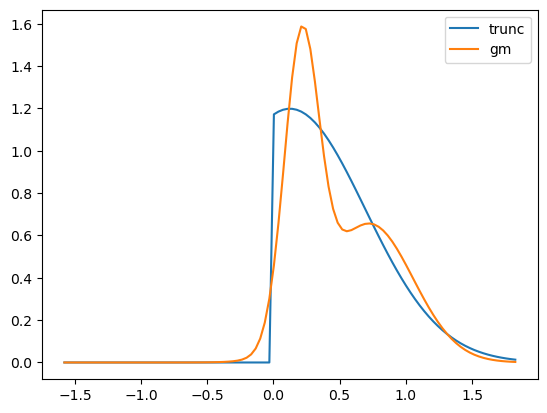

In [99]:
from scipy.stats import truncnorm
from scipy.stats import norm

idx = 0

print('trunc gauss', trunc_gauss[idx])
print('gm params', output_mix[idx])

#output_mix has the following structure: [weights, means, covs]
params = trunc_gauss[idx]
weights = output_mix[idx][:2]
means = output_mix[idx][2:4]
covs = output_mix[idx][4:]

loc = params[1]
scale = torch.sqrt(params[2])
a = -loc/scale
b = np.inf

x = np.linspace(loc-3*scale, loc+3*scale, 100)

y_trunc = truncnorm.pdf(x, a, b, loc, scale)
plt.plot(x, y_trunc, label='trunc')


y_gm = sum([weights[i]*norm.pdf(x, means[i], np.sqrt(covs[i])) for i in range(2)])
plt.plot(x, y_gm.reshape(x.shape), label='gm')

plt.legend()

In [100]:
training_dataset = torch.hstack((trunc_gauss, torch.tensor(output_mix, dtype=torch.float32)))

In [101]:
#torch.save(training_dataset, './params/training_dataset.pt')
training_dataset = torch.load('./params/training_dataset.pt')

In [102]:
#training_dataset = DataLoader(training_dataset, batch_size = 64, shuffle=True)

from torch.utils.data import DataLoader, random_split

# Assuming training_dataset is your dataset
dataset_size = len(training_dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(training_dataset, [train_size, test_size])

# Create DataLoader objects for training and testing sets
training_dataset = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [103]:
output_mix

[array([0.54367633, 0.45632367, 0.72325697, 0.21047449, 0.10929605,
        0.01712936]),
 array([0.55202573, 0.44797427, 0.59157844, 0.6888135 , 0.00274296,
        0.00298588]),
 array([5.70253732e-01, 4.29746268e-01, 7.37483138e+00, 7.50754487e+00,
        5.57175669e-03, 6.02787551e-03]),
 array([0.45886055, 0.54113945, 0.50537032, 1.05762344, 0.07020929,
        0.10997782]),
 array([0.38462615, 0.61537385, 0.5593626 , 0.21027853, 0.03942355,
        0.01727432]),
 array([4.91147446e-01, 5.08852554e-01, 5.01607130e-01, 4.76386258e-01,
        2.46815286e-04, 2.17684316e-04]),
 array([ 0.52985978,  0.47014022, 18.47954754, 20.58365812,  1.68285409,
         1.71674483]),
 array([ 0.45779334,  0.54220666, 11.77530577,  9.21127176,  2.90631578,
         2.80241368]),
 array([ 0.48699671,  0.51300329, 19.13445715, 17.99471053,  0.61748371,
         0.53598346]),
 array([0.52988181, 0.47011819, 0.12056913, 0.27313562, 0.0049301 ,
        0.00743169]),
 array([0.6860791 , 0.3139209 , 0.

In [104]:
training_dataset.dataset[1]

tensor([1.0000, 0.9946, 0.0271, 0.6131, 0.3869, 0.9172, 1.1214, 0.0173, 0.0183])

#### Loss function

In [133]:
EPS = 10**(-6)

def mean_square_loss(true_gm, pred_gm):

    loss_weights = (4*torch.abs((true_gm[:2] - pred_gm[:2])/(true_gm[:2] + pred_gm[:2]))).sum()
    #print('weights', loss_weights)
    true_means = true_gm[2:4]
    pred_means = pred_gm[2:4]
    loss_means = (4*torch.abs((true_means-pred_means)/(true_means+pred_means))).sum()
    #print('means', loss_means)
    true_covs = true_gm[4:]
    pred_covs = pred_gm[4:]
    loss_covs = (4*torch.abs((true_covs - pred_covs)/(true_covs + pred_covs))).sum()
    #print('covs', loss_covs)
    return loss_weights + loss_means + loss_covs
    

def loss_function_minibatch(tbatch, new_pi, new_mu, new_sigma):
    total_loss = torch.tensor(0.)
    output_params = torch.hstack((new_pi, new_mu, new_sigma))
    for idx, inp in enumerate(tbatch):
        loss = mean_square_loss(inp[3:], output_params[idx])
        total_loss += loss
    return total_loss/tbatch.shape[0]

def train_loop_minibatch(training_dataloader, model, loss_fn, optimizer):

    model.train()
    counter = 0
    losses = []

    for batch_idx, tbatch in enumerate(training_dataset):

        pi_new, mu_new, sigma_new = model(tbatch[:,:3])
        
        loss = loss_fn(tbatch, pi_new, mu_new, sigma_new)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #print information
        if counter % 500 == 0:
            loss = loss.item()
            print(f"loss: {loss:>7f}")
            losses.append(loss)

        #if counter % 1000 == 0:
            #print('trunc:', tbatch[0,:3])
            #print('EM:', tbatch[0,3:])
            #print('pred:', pi_new[0], mu_new[0], sigma_new[0])

        counter += 1

    return losses

#### Training 10 epochs

In [143]:
ncomp_inp = 1
ncomp_out = 2
xdim = 1

epochs = 500

model = ApproxTruncation(xdim=xdim, num_component_input=ncomp_inp, num_component_output=ncomp_out)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for t in range(epochs):
    print(f"\nEpoch {t+1}\n-------------------------------")
    losses = train_loop_minibatch(training_dataset, model, loss_function_minibatch, optimizer)

print("Done!")
torch.save(model, 'params/truncNNdim1-EM1.pth')


Epoch 1
-------------------------------
loss: 10.765156
loss: 7.353869
loss: 5.279058

Epoch 2
-------------------------------
loss: 5.724696
loss: 3.908642
loss: 4.100467

Epoch 3
-------------------------------
loss: 4.032950
loss: 3.588347
loss: 3.501552

Epoch 4
-------------------------------
loss: 3.455786
loss: 2.945122
loss: 3.403076

Epoch 5
-------------------------------
loss: 2.359044
loss: 2.924297
loss: 3.079136

Epoch 6
-------------------------------
loss: 2.479202
loss: 2.593163
loss: 2.667631

Epoch 7
-------------------------------
loss: 2.265220
loss: 2.638864
loss: 2.445438

Epoch 8
-------------------------------
loss: 2.940250
loss: 2.335138
loss: 2.442847

Epoch 9
-------------------------------
loss: 2.176358
loss: 2.553706
loss: 2.401185

Epoch 10
-------------------------------
loss: 2.476985
loss: 1.980895
loss: 2.411704

Epoch 11
-------------------------------
loss: 2.517801
loss: 2.078028
loss: 2.462000

Epoch 12
-------------------------------
loss: 2.7

### Testing

true weights:  [0.43643796 0.56356204]
pred weights:  [0.5295244 0.4704756]
true means:  [1.2415054 0.5237785]
pred means:  [0.5384544 1.2075965]
true vars:  [0.20008636 0.09529436]
pred vars:  [0.09997845 0.17199895]
------------------------
true weights:  [0.5382037  0.46179625]
pred weights:  [0.50432503 0.49567497]
true means:  [1.139846  1.8116392]
pred means:  [1.1787391 1.6189551]
true vars:  [0.16677575 0.18771178]
pred vars:  [0.15287696 0.15194243]
------------------------
true weights:  [0.35163385 0.64836615]
pred weights:  [0.5800877  0.41991228]
true means:  [0.22807556 0.0780743 ]
pred means:  [0.07872205 0.21812722]
true vars:  [0.00835161 0.00252398]
pred vars:  [0.00260964 0.00771551]
------------------------
true weights:  [0.4833833 0.5166167]
pred weights:  [0.5076399  0.49236012]
true means:  [6.209826 9.421894]
pred means:  [7.0627213 9.101714 ]
true vars:  [4.0434127 4.3221054]
pred vars:  [3.8467286 3.8464093]
------------------------
true weights:  [0.537382 0

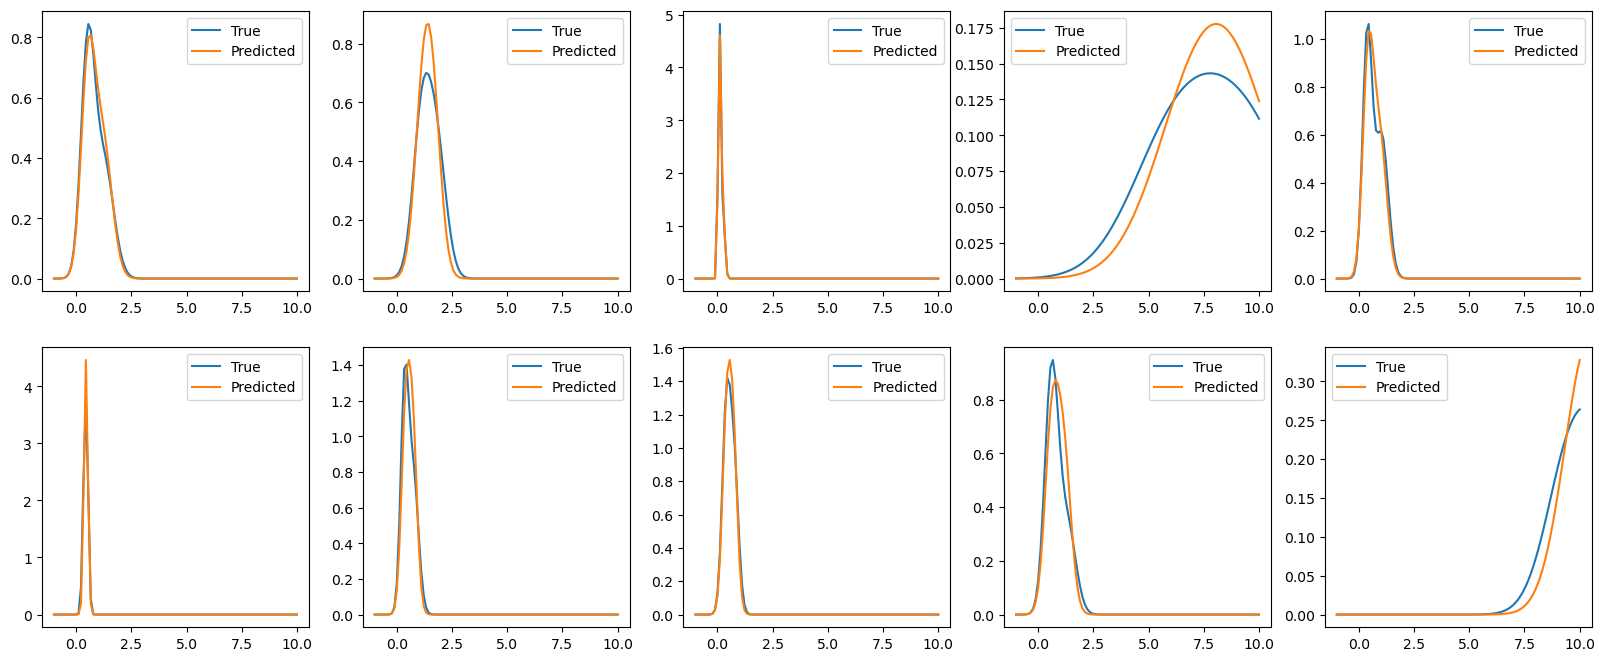

true weights:  [0.4001978 0.5998022]
pred weights:  [0.5079239 0.4920761]
true means:  [1.1633294 0.508438 ]
pred means:  [0.5278869 1.0151471]
true vars:  [0.11709733 0.05838882]
pred vars:  [0.07491713 0.08848973]
------------------------
true weights:  [0.43602842 0.5639716 ]
pred weights:  [0.5042023 0.4957977]
true means:  [0.75110483 1.0917721 ]
pred means:  [0.83265704 1.0197865 ]
true vars:  [0.04293224 0.03688173]
pred vars:  [0.03698871 0.03677308]
------------------------
true weights:  [0.41758093 0.5824191 ]
pred weights:  [0.51983124 0.48016876]
true means:  [0.5923528  0.23169284]
pred means:  [0.24537092 0.5361832 ]
true vars:  [0.03765512 0.01784025]
pred vars:  [0.0195167  0.02962794]
------------------------
true weights:  [0.5833755 0.4166245]
pred weights:  [0.50547886 0.4945211 ]
true means:  [13.962526 14.242327]
pred means:  [13.903593  13.9340105]
true vars:  [0.03371571 0.03031897]
pred vars:  [0.03160898 0.03208909]
------------------------
true weights:  [0.

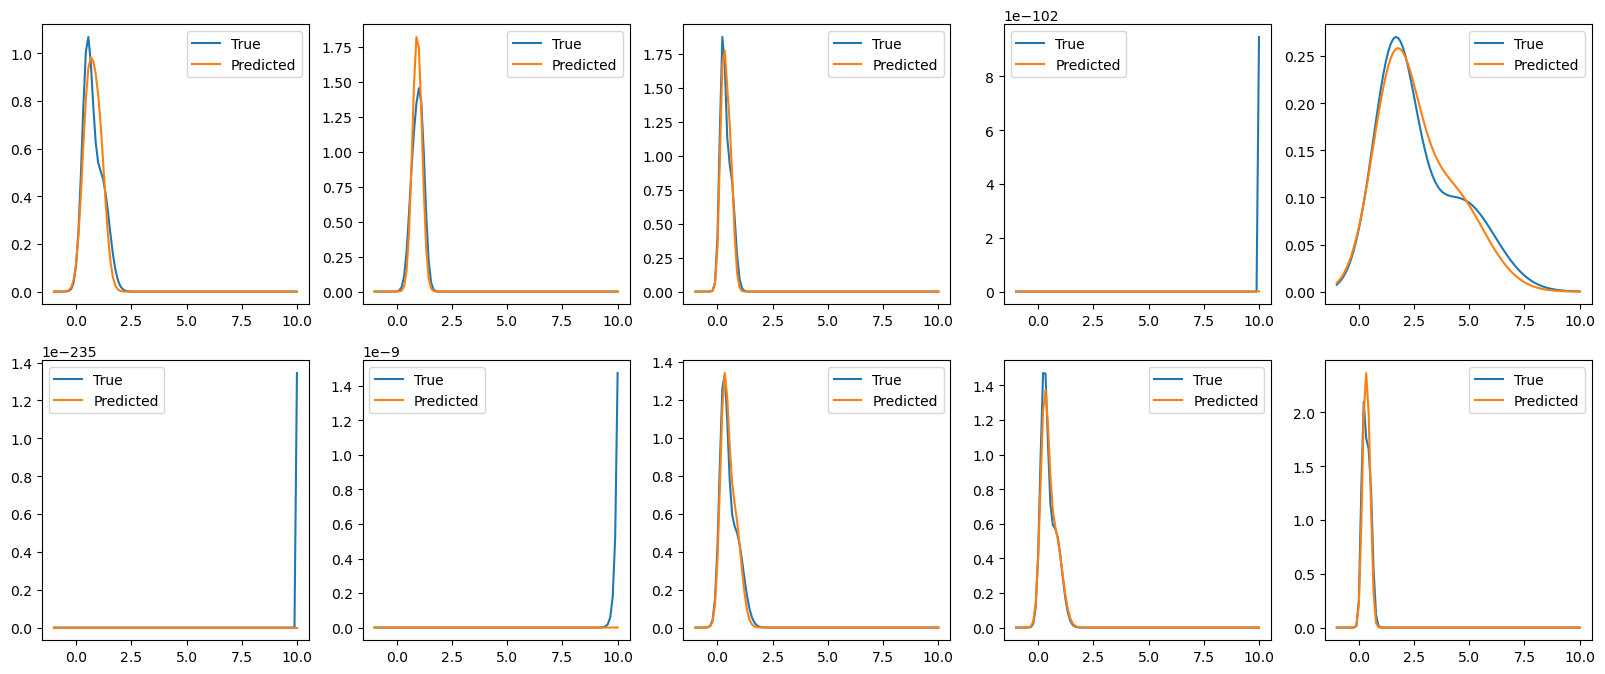

true weights:  [0.41171023 0.5882898 ]
pred weights:  [0.5627085  0.43729156]
true means:  [1.2145722  0.38379177]
pred means:  [0.4631703 1.1905124]
true vars:  [0.18703404 0.06402023]
pred vars:  [0.08915672 0.22238334]
------------------------
true weights:  [0.6802212  0.31977883]
pred weights:  [0.5533106  0.44668943]
true means:  [0.48154595 1.2728384 ]
pred means:  [0.46274757 1.1500816 ]
true vars:  [0.09196313 0.23576823]
pred vars:  [0.08458176 0.18903296]
------------------------
true weights:  [0.5773404 0.4226596]
pred weights:  [0.5059458  0.49405417]
true means:  [12.649927 11.310379]
pred means:  [11.878369 12.23812 ]
true vars:  [0.80932915 0.7310617 ]
pred vars:  [0.7128067  0.71518254]
------------------------
true weights:  [0.58312476 0.41687524]
pred weights:  [0.5091109  0.49088898]
true means:  [11.170935 16.52361 ]
pred means:  [15.064685 14.654504]
true vars:  [7.5325212 7.501661 ]
pred vars:  [8.425637 8.41083 ]
------------------------
true weights:  [0.4666

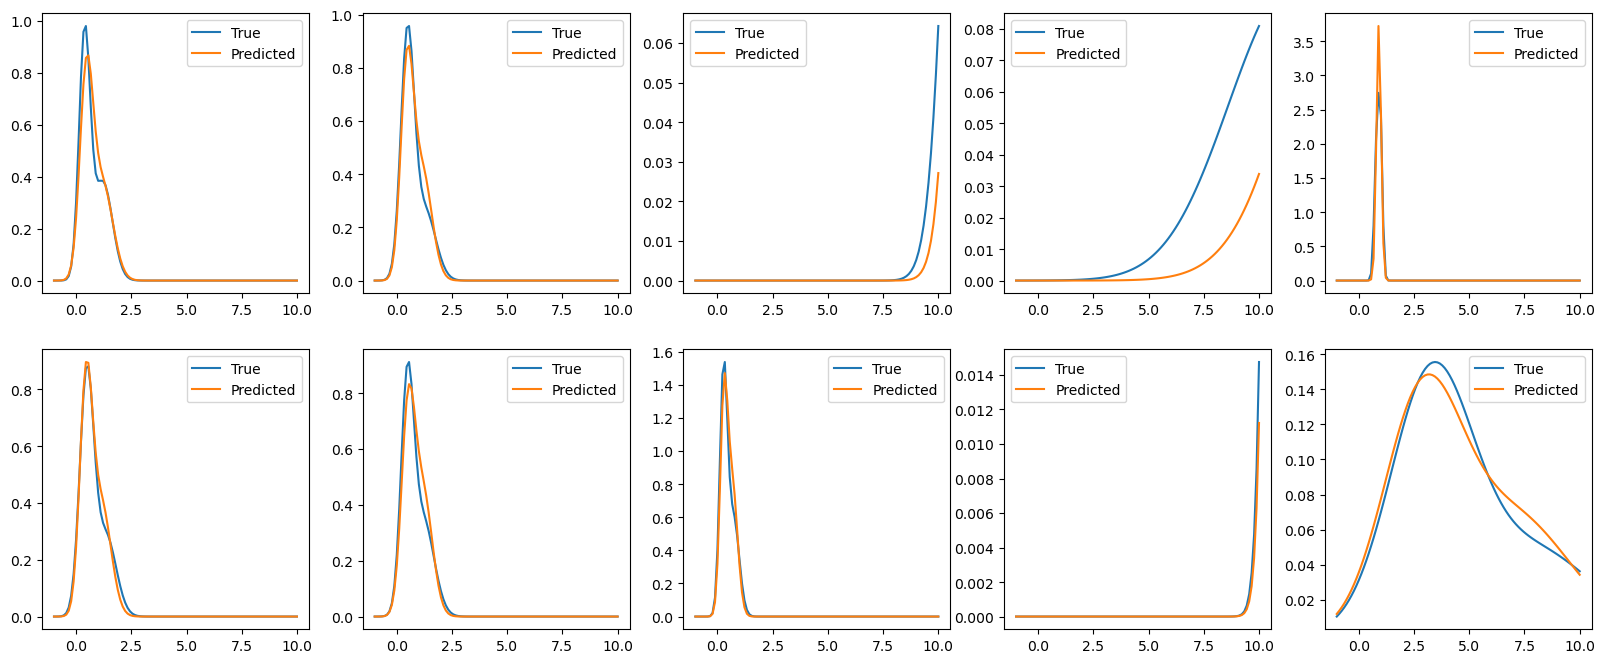

true weights:  [0.5784326  0.42156735]
pred weights:  [0.5054422  0.49455786]
true means:  [14.512856 12.448638]
pred means:  [13.643954 14.055992]
true vars:  [1.0474498 0.955807 ]
pred vars:  [1.1152157 1.1172539]
------------------------
true weights:  [0.5731816  0.42681837]
pred weights:  [0.5071528 0.4928472]
true means:  [11.6357765 14.1936865]
pred means:  [12.853327 13.533956]
true vars:  [3.208451  3.5112376]
pred vars:  [2.9875572 3.001404 ]
------------------------
true weights:  [0.5124063 0.4875937]
pred weights:  [0.5052905  0.49470943]
true means:  [15.474295 15.94715 ]
pred means:  [15.541718 15.477377]
true vars:  [0.07058346 0.06406528]
pred vars:  [0.08532897 0.08483295]
------------------------
true weights:  [0.64938366 0.35061634]
pred weights:  [0.56915516 0.43084484]
true means:  [1.5512162 4.5500207]
pred means:  [1.5256644 3.8597624]
true vars:  [1.0779109 3.039604 ]
pred vars:  [0.9907844 2.581943 ]
------------------------
true weights:  [0.5202825 0.479717

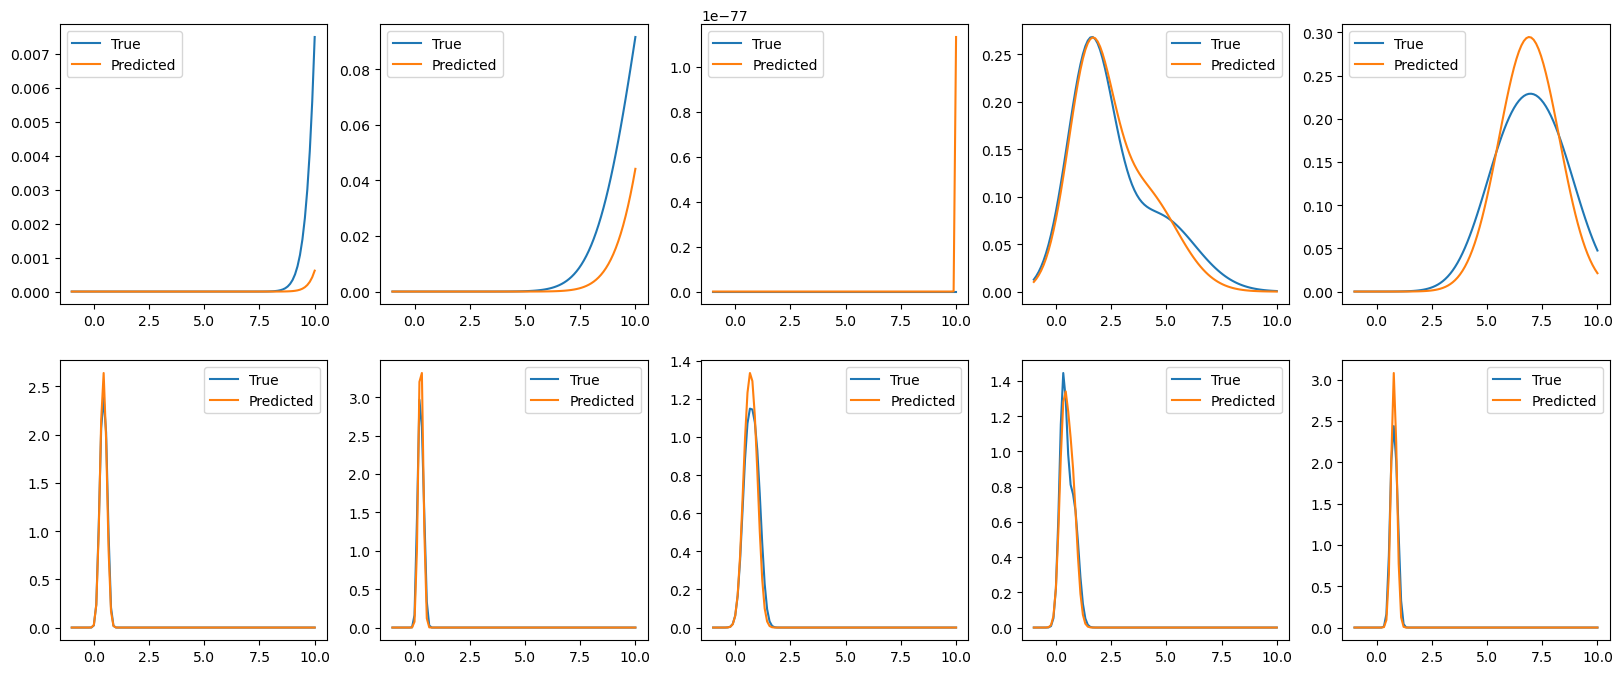

true weights:  [0.51542467 0.48457533]
pred weights:  [0.49809876 0.50190127]
true means:  [0.1018323 0.1478867]
pred means:  [0.1115353  0.13291538]
true vars:  [0.00097673 0.00099364]
pred vars:  [0.00084543 0.00085123]
------------------------
true weights:  [0.6087867  0.39121327]
pred weights:  [0.5544208 0.4455791]
true means:  [0.28844693 0.8398805 ]
pred means:  [0.30824187 0.77404374]
true vars:  [0.03303424 0.11244926]
pred vars:  [0.03791192 0.0876705 ]
------------------------
true weights:  [0.55530065 0.44469938]
pred weights:  [0.5035115 0.4964885]
true means:  [3.693129  5.3294106]
pred means:  [3.7737434 4.7526965]
true vars:  [1.2313614 1.1342024]
pred vars:  [1.0960009 1.0902077]
------------------------
true weights:  [0.4451857  0.55481434]
pred weights:  [0.5111562  0.48884377]
true means:  [19.893663 13.680082]
pred means:  [17.104223 15.21398 ]
true vars:  [ 9.647501 10.017195]
pred vars:  [13.035951 12.937165]
------------------------
true weights:  [0.49213728

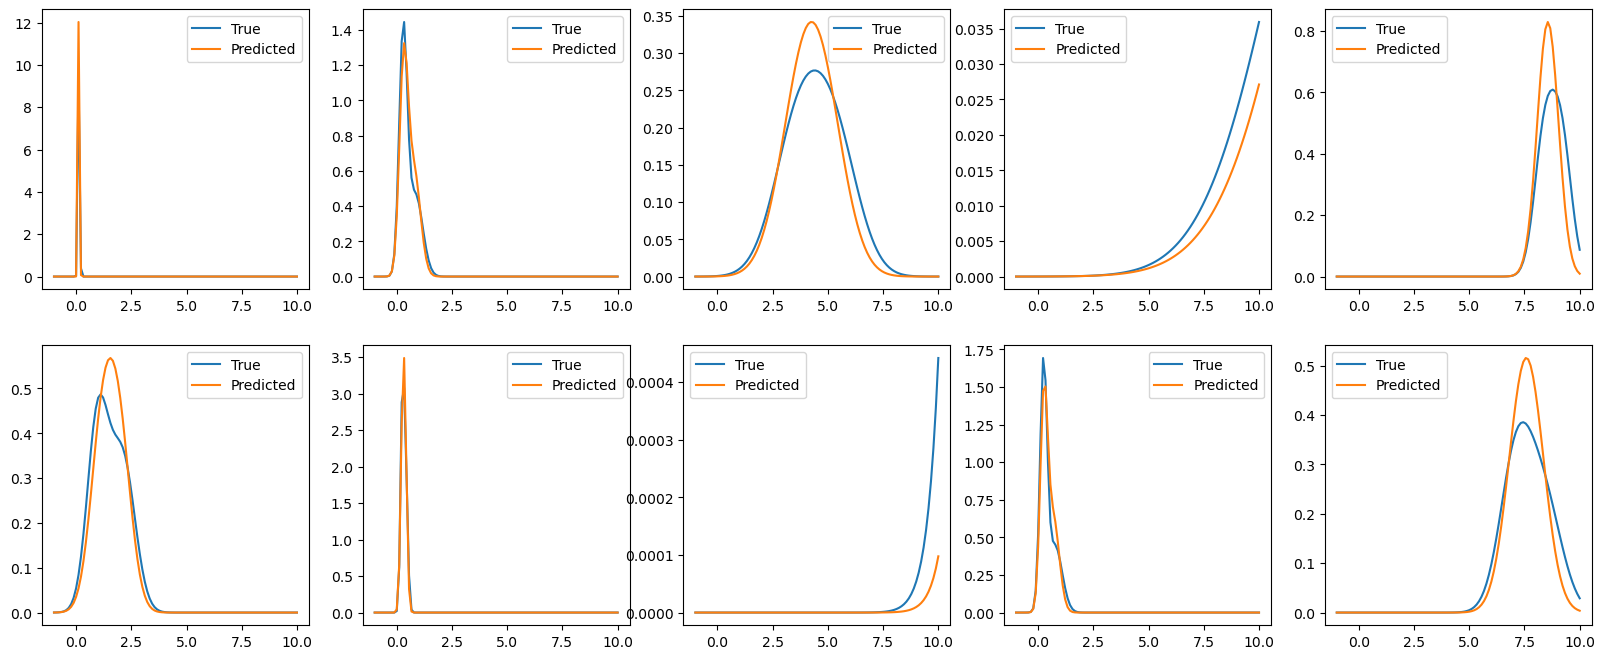

true weights:  [0.6546904  0.34530964]
pred weights:  [0.5324185 0.4675815]
true means:  [0.11523177 0.30014887]
pred means:  [0.12262356 0.27609947]
true vars:  [0.00477553 0.00965969]
pred vars:  [0.00476092 0.00785915]
------------------------
true weights:  [0.4289473  0.57105273]
pred weights:  [0.5347049  0.46529508]
true means:  [0.75753313 0.3170946 ]
pred means:  [0.31335643 0.73202044]
true vars:  [0.09137101 0.03592952]
pred vars:  [0.03495226 0.06545192]
------------------------
true weights:  [0.45340094 0.54659903]
pred weights:  [0.5059479  0.49405208]
true means:  [15.768475 14.797499]
pred means:  [15.096476 15.165256]
true vars:  [0.44058162 0.3775859 ]
pred vars:  [0.3869459 0.3865832]
------------------------
true weights:  [0.5022585  0.49774152]
pred weights:  [0.50804126 0.4919587 ]
true means:  [11.769718 15.070176]
pred means:  [12.912583 13.931354]
true vars:  [4.9710503 4.5439277]
pred vars:  [4.423934  4.4746456]
------------------------
true weights:  [0.67

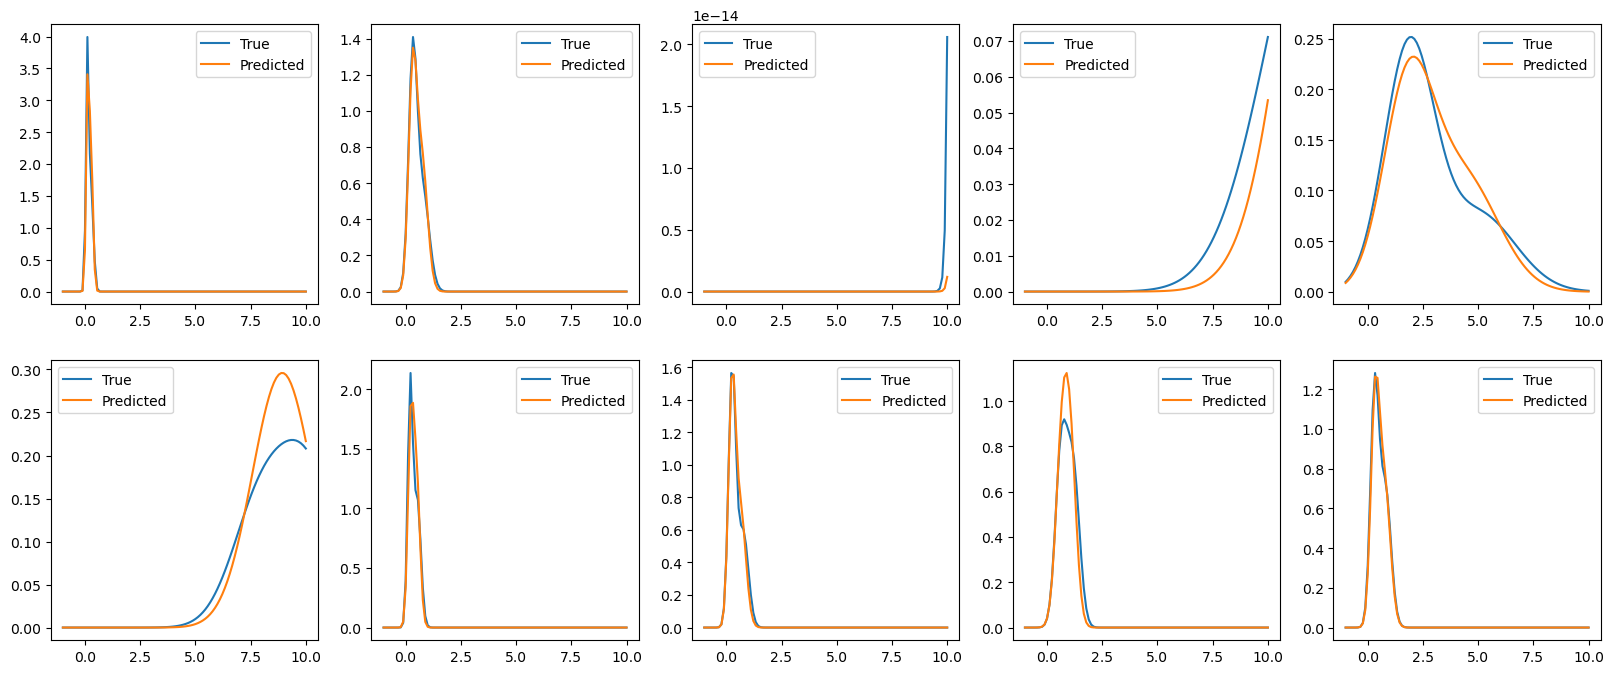

true weights:  [0.5792456  0.42075437]
pred weights:  [0.5087723  0.49122778]
true means:  [0.63825715 1.306442  ]
pred means:  [0.62104094 1.2045624 ]
true vars:  [0.10705917 0.17984062]
pred vars:  [0.10554899 0.12788787]
------------------------
true weights:  [0.49762902 0.502371  ]
pred weights:  [0.5079252  0.49207485]
true means:  [19.51905  15.604611]
pred means:  [18.168098 17.717625]
true vars:  [5.586842 5.800485]
pred vars:  [5.3941298 5.4555945]
------------------------
true weights:  [0.5218894  0.47811064]
pred weights:  [0.5063996  0.49360046]
true means:  [13.738809 14.42797 ]
pred means:  [13.861419 13.85793 ]
true vars:  [0.23884656 0.22396131]
pred vars:  [0.21514647 0.21339664]
------------------------
true weights:  [0.50303906 0.49696094]
pred weights:  [0.50358135 0.4964186 ]
true means:  [0.53855366 0.36691934]
pred means:  [0.38347533 0.5168626 ]
true vars:  [0.01812115 0.01373125]
pred vars:  [0.01348513 0.01348002]
------------------------
true weights:  [0.

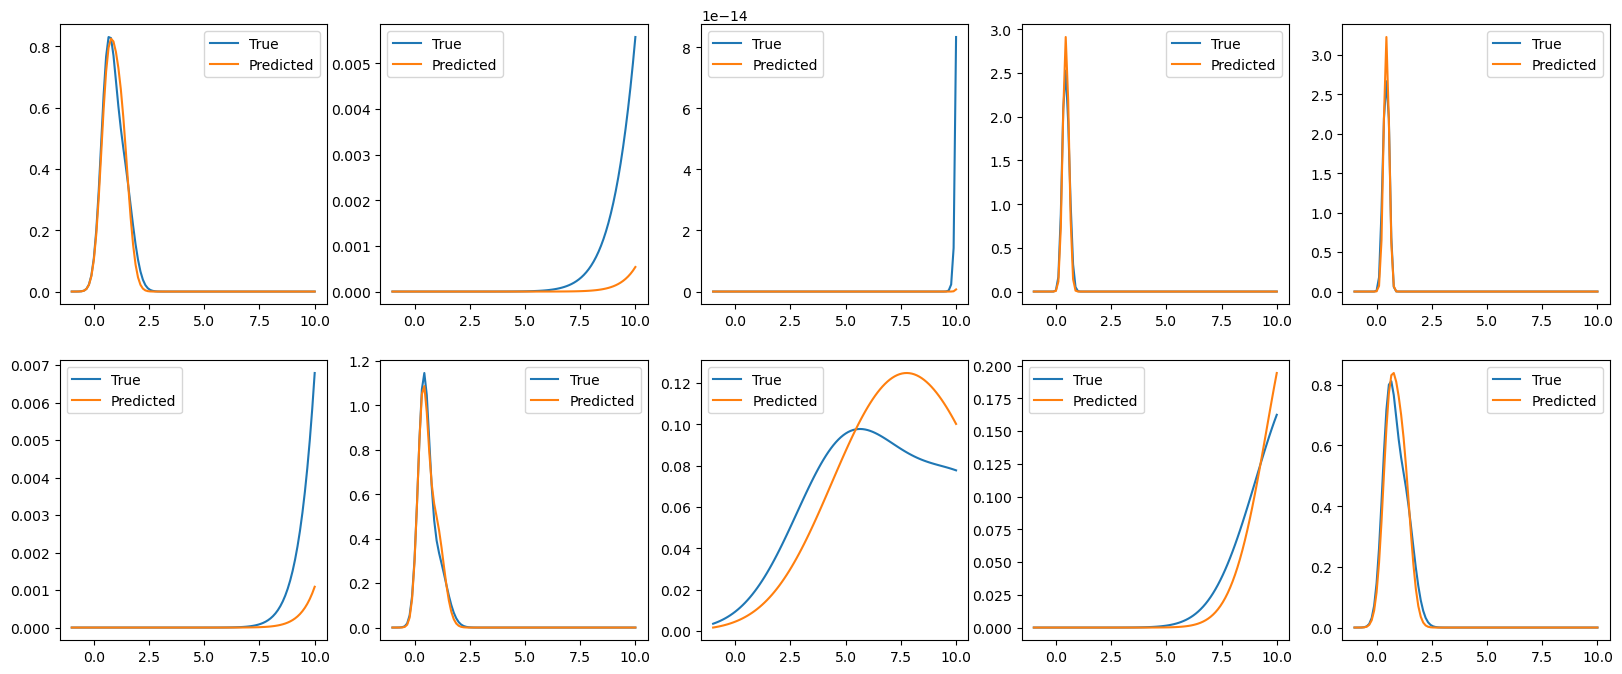

true weights:  [0.49454618 0.5054538 ]
pred weights:  [0.5057261  0.49427387]
true means:  [7.8447156 7.3801036]
pred means:  [7.547342  7.5281987]
true vars:  [0.10224145 0.12239985]
pred vars:  [0.09655971 0.09619196]
------------------------
true weights:  [0.5190006 0.4809994]
pred weights:  [0.50422543 0.49577463]
true means:  [0.7018165  0.48239717]
pred means:  [0.50846744 0.67270553]
true vars:  [0.02344424 0.0217857 ]
pred vars:  [0.02136382 0.02123627]
------------------------
true weights:  [0.4973351 0.5026649]
pred weights:  [0.50339866 0.49660128]
true means:  [2.2409618 1.0898741]
pred means:  [1.2298695 2.0562446]
true vars:  [0.3276636  0.28615314]
pred vars:  [0.31753895 0.32202888]
------------------------
true weights:  [0.4289515 0.5710485]
pred weights:  [0.52253145 0.4774685 ]
true means:  [1.429587   0.59222555]
pred means:  [0.6127928 1.3200704]
true vars:  [0.2978661  0.12155419]
pred vars:  [0.12253454 0.18996575]
------------------------
true weights:  [0.43

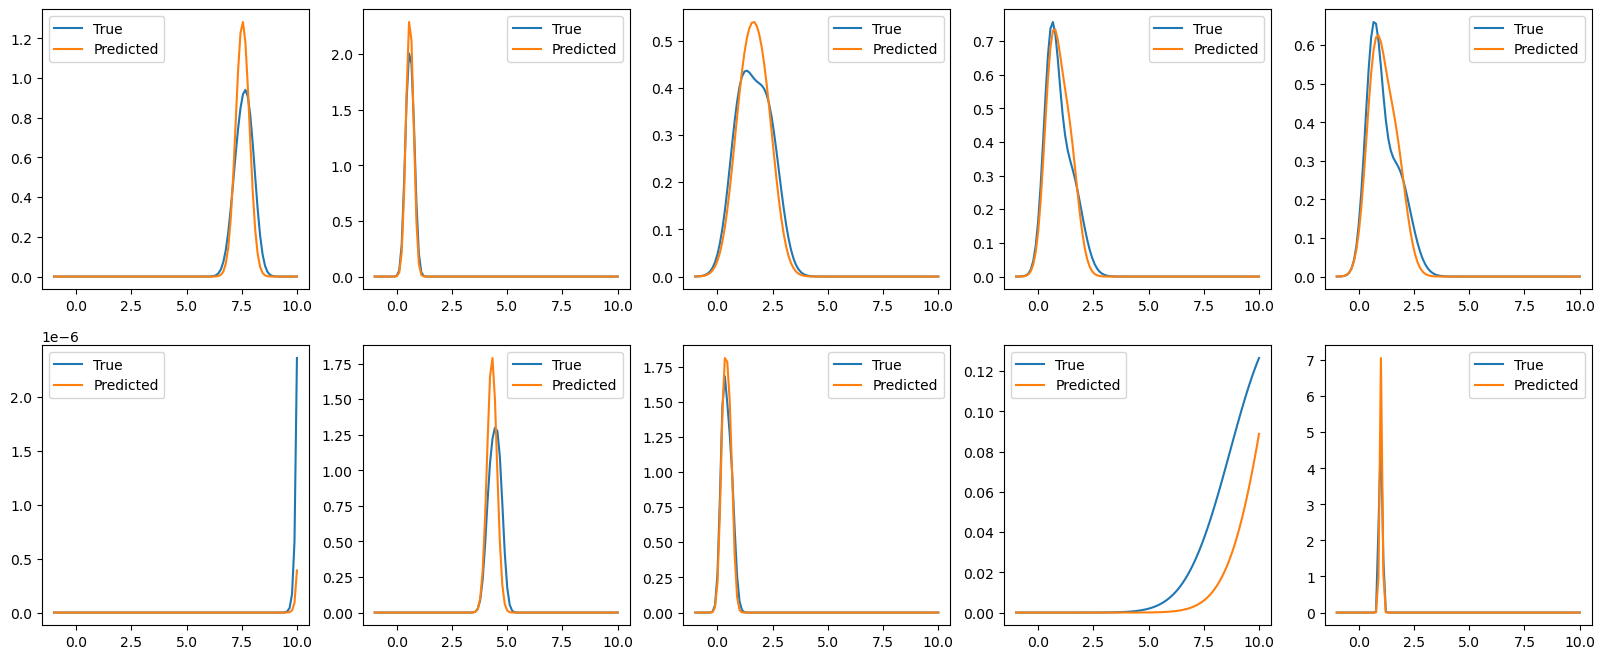

true weights:  [0.5181985  0.48180148]
pred weights:  [0.5180216  0.48197848]
true means:  [0.33999392 0.13427623]
pred means:  [0.16466616 0.34304088]
true vars:  [0.01204953 0.00622128]
pred vars:  [0.00799121 0.01094531]
------------------------
true weights:  [0.4866464 0.5133536]
pred weights:  [0.5064884  0.49351168]
true means:  [8.871857  7.8526626]
pred means:  [8.084331 8.455693]
true vars:  [0.3910698  0.38813883]
pred vars:  [0.39738506 0.39934543]
------------------------
true weights:  [0.5958747 0.4041253]
pred weights:  [0.50408936 0.49591073]
true means:  [0.48265836 0.6796824 ]
pred means:  [0.4899457  0.65818006]
true vars:  [0.01960749 0.02466879]
pred vars:  [0.02148437 0.02134519]
------------------------
true weights:  [0.5924078  0.40759215]
pred weights:  [0.55427146 0.44572854]
true means:  [2.7777677 7.175583 ]
pred means:  [2.6752408 6.729554 ]
true vars:  [3.271684  9.4314995]
pred vars:  [3.1650574 7.58641  ]
------------------------
true weights:  [0.5883

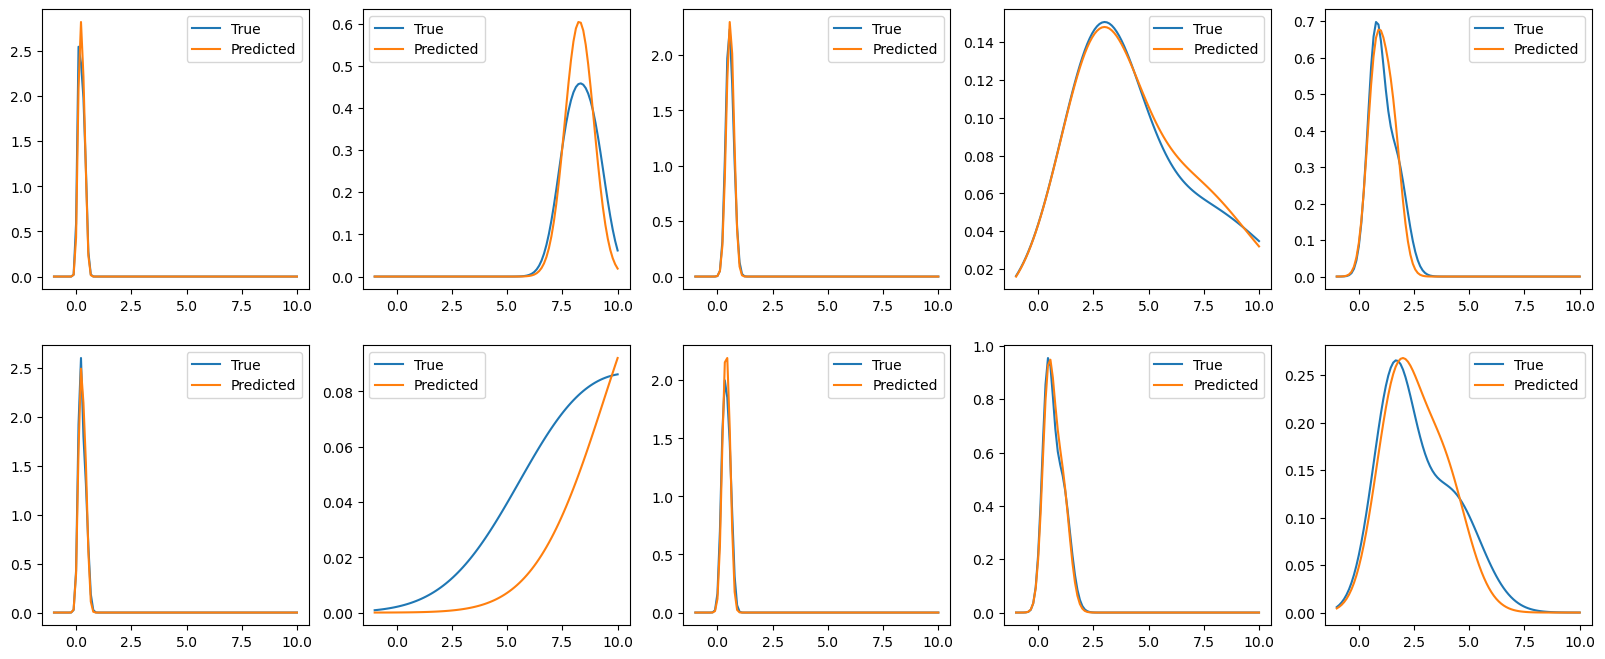

true weights:  [0.50014883 0.49985117]
pred weights:  [0.5042578  0.49574223]
true means:  [1.1843113  0.70407915]
pred means:  [0.7576983 1.0572164]
true vars:  [0.06735412 0.06257994]
pred vars:  [0.06522109 0.06424209]
------------------------
true weights:  [0.43209866 0.5679014 ]
pred weights:  [0.5027827  0.49721724]
true means:  [0.43066376 0.36536437]
pred means:  [0.39486343 0.4235889 ]
true vars:  [0.00128404 0.00146602]
pred vars:  [0.00137845 0.00141755]
------------------------
true weights:  [0.5822679  0.41773215]
pred weights:  [0.5101756  0.48982438]
true means:  [16.795994 21.631207]
pred means:  [20.028603 17.448053]
true vars:  [11.925519 11.506552]
pred vars:  [10.818737 10.830469]
------------------------
true weights:  [0.3487237 0.6512763]
pred weights:  [0.5569404 0.4430596]
true means:  [0.7828961 0.2860642]
pred means:  [0.2763654 0.7008991]
true vars:  [0.10114951 0.03246558]
pred vars:  [0.03107183 0.07417322]
------------------------
true weights:  [0.4556

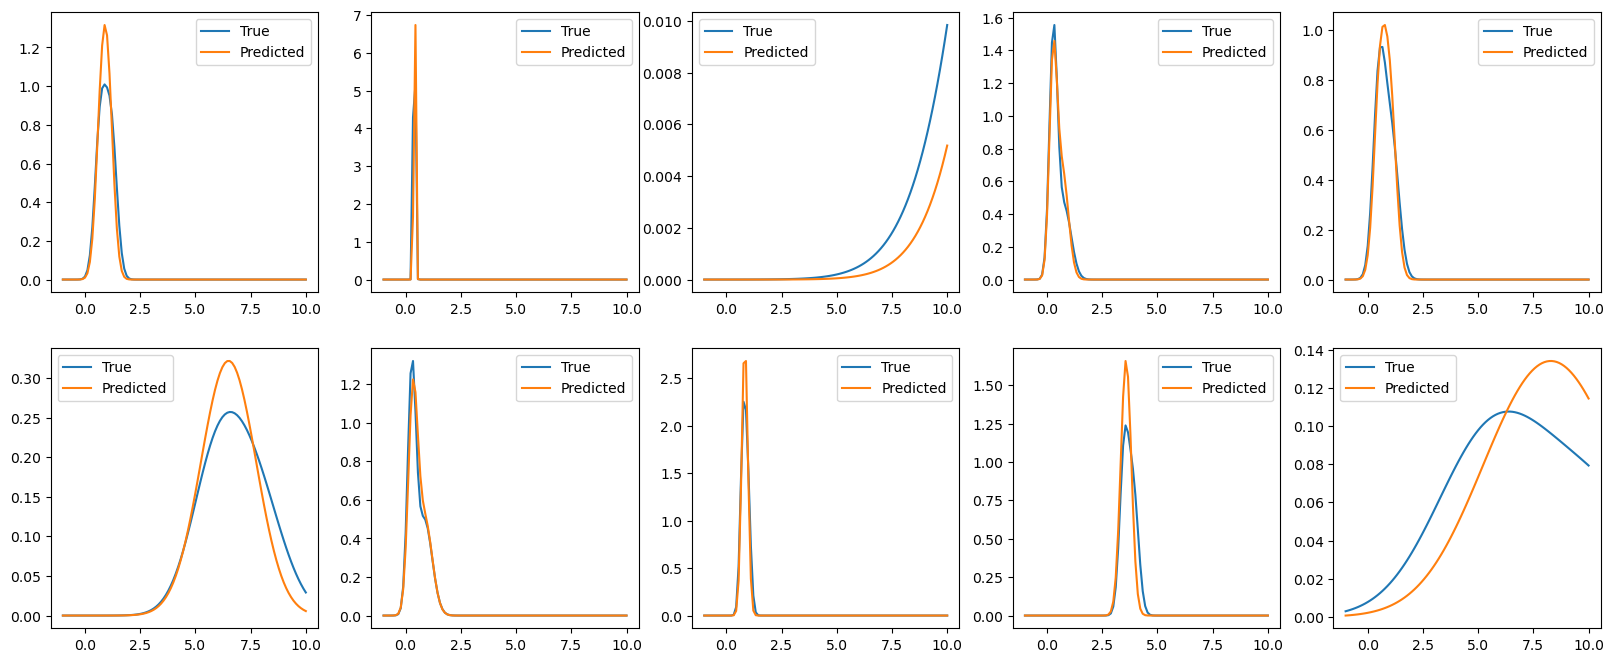

<Figure size 2000x800 with 0 Axes>

In [144]:
# Function to plot Gaussian Mixture
def plot_gm(x, pis, mus, sigmas, ncomp=2):
    return sum([pis[i]*norm.pdf(x, loc=mus[i], scale=np.sqrt(sigmas[i])) for i in range(ncomp)])

# Plotting
x = np.linspace(-1, 10, 100)



for i, batch in enumerate(test_loader):
    plt.figure(figsize=(20, 8))
    if i >= 10:  # Plot only the first 10 batches
        break

    true_params = batch[:, 3:]
    pi_pred, mu_pred, sigma_pred = model(batch[:, :3])

    for j in range(len(batch)):
        if j >= 10:  # Plot only the first 10 batches
            break
        true_weights = true_params[j, :2].numpy()
        true_means = true_params[j, 2:4].numpy()
        true_vars = true_params[j, 4:].numpy()

        pred_weights = pi_pred[j].detach().numpy()
        pred_means = mu_pred[j].detach().numpy()
        pred_vars = sigma_pred[j].detach().numpy()

        y_true = plot_gm(x, true_weights, true_means, true_vars)
        y_pred = plot_gm(x, pred_weights, pred_means, pred_vars)

        print('true weights: ', true_weights)
        print('pred weights: ', pred_weights)
        print('true means: ', true_means)
        print('pred means: ', pred_means)
        print('true vars: ', true_vars)
        print('pred vars: ', pred_vars)
        print('------------------------')
        plt.subplot(2, 5,  j + 1)
        plt.plot(x, y_true, label='True')
        plt.plot(x, y_pred, label='Predicted')
        plt.legend()
    plt.show()

plt.tight_layout()
plt.show()

#### Debug

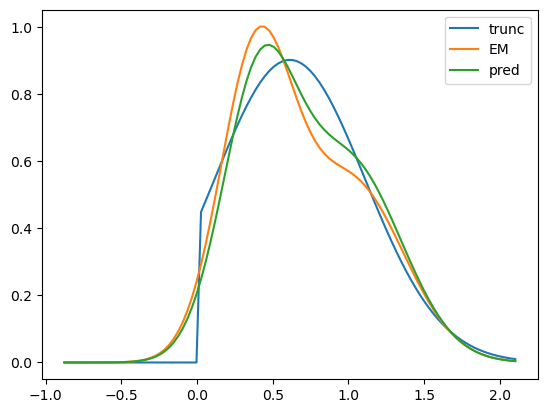

In [110]:
from scipy.stats import truncnorm
from scipy.stats import norm


trunc_params  = torch.tensor([1.0000, 0.6129, 0.2462])
em_params = torch.tensor([0.4680, 0.5320, 1.0158, 0.3885, 0.1212, 0.0575])
pred_params = torch.tensor([0.5127, 0.4873, 1.0055, 0.4072, 0.12, 0.06]) #torch.tensor([0.5127, 0.4873, 2.0055, 1.7072, 0.9804, 0.9270])


params = trunc_gauss[idx]

em_weights = em_params[:2]
em_means = em_params[2:4]
em_covs = em_params[4:]

pred_weights = pred_params[:2]
pred_means = pred_params[2:4]
pred_covs = pred_params[4:]

loc = trunc_params[1]
scale = torch.sqrt(trunc_params[2])
a = -loc/scale
b = np.inf

x = np.linspace(loc-3*scale, loc+3*scale, 100)

y_trunc = truncnorm.pdf(x, a, b, loc, scale)
plt.plot(x, y_trunc, label='trunc')

y_em = sum([em_weights[i]*norm.pdf(x, em_means[i], np.sqrt(em_covs[i])) for i in range(2)])
plt.plot(x, y_em.reshape(x.shape), label='EM')

y_gm = sum([pred_weights[i]*norm.pdf(x, pred_means[i], np.sqrt(pred_covs[i])) for i in range(2)])
plt.plot(x, y_gm.reshape(x.shape), label='pred')

plt.legend()

In [111]:
mean_square_loss(em_params, pred_params)

tensor(0.0023)

In [112]:
print('em params', em_params)
print('pred params', pred_params)

mean_square_loss(em_params, torch.tensor([0.5127, 0.4873, 1.0055, 0.4072, 0.9804, 0.9270]))

em params tensor([0.4680, 0.5320, 1.0158, 0.3885, 0.1212, 0.0575])
pred params tensor([0.5127, 0.4873, 1.0055, 0.4072, 0.1200, 0.0600])


tensor(0.7213)

In [113]:
print('em params', em_params)
print('pred params', pred_params)

mean_square_loss(em_params, torch.tensor([0.5127, 0.4873, 2.0055, 1.7072, 0.12, 0.06]))

em params tensor([0.4680, 0.5320, 1.0158, 0.3885, 0.1212, 0.0575])
pred params tensor([0.5127, 0.4873, 1.0055, 0.4072, 0.1200, 0.0600])


tensor(0.5790)

In [114]:
mean_square_loss(em_params, torch.tensor([0.5127, 0.4873, 1.0055, 0.4072, 0.12, 0.06]))

tensor(0.0023)